In [1]:
%matplotlib notebook
import sympy
import matplotlib.pyplot as plt
import numpy as np

In [12]:
!pip install line_profiler

In [14]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


<IPython.core.display.Javascript object>


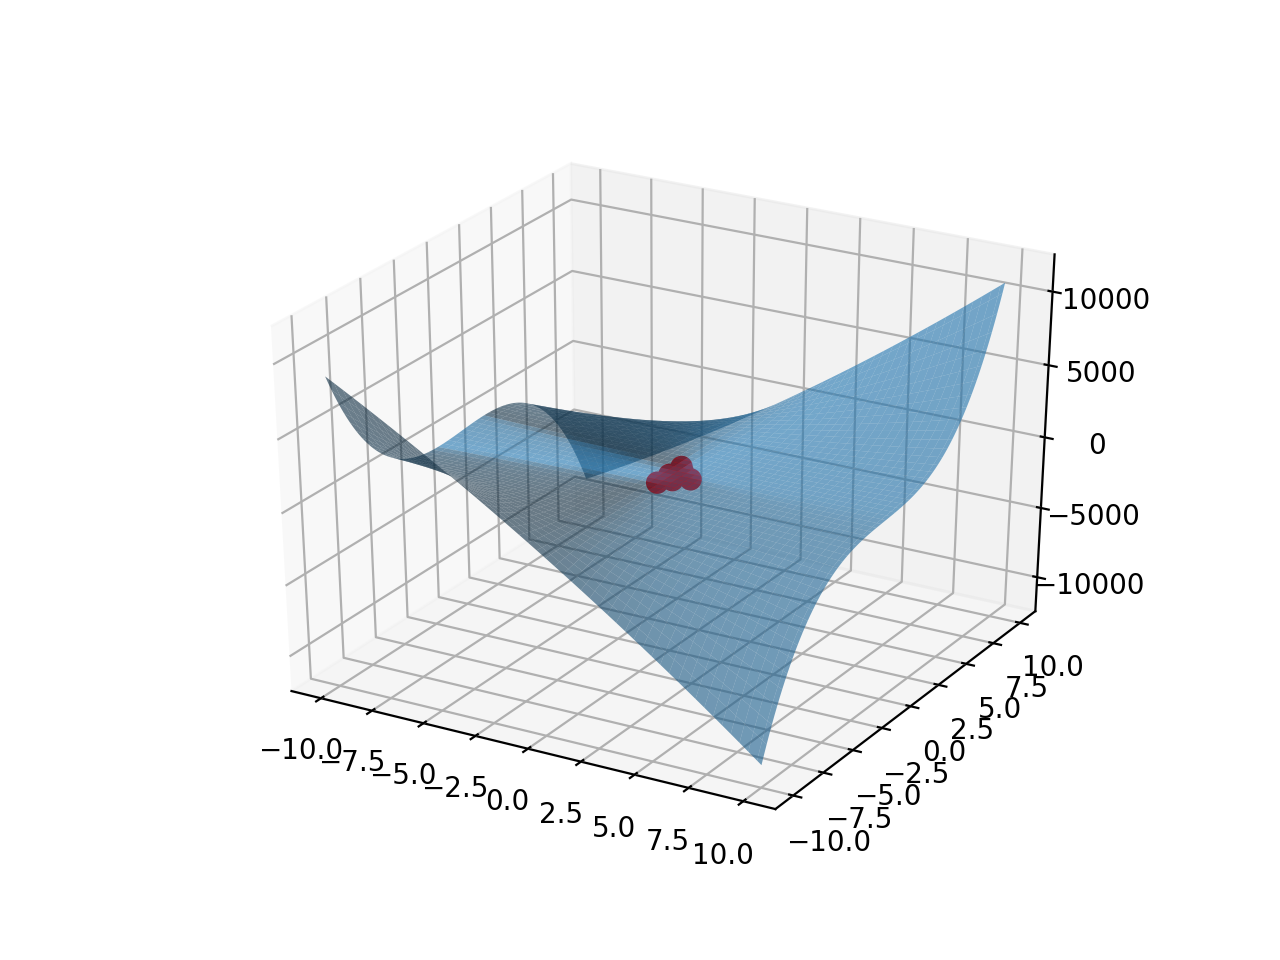

In [21]:
%lprun -f find_local_extremas find_local_extremas(['x', 'y'], 'y*(x**2) + x*(y**3) - x*y')

Timer unit: 1e-06 s

Total time: 0.309226 s
File: <ipython-input-17-ab626eda96ae>
Function: find_local_extremas at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def find_local_extremas(varnames, func, bounds=None):
     2                                               """
     3                                               varnames: ['x', 'y']
     4                                               func: 'y*(x**2) + x*(y**3) - x*y'
     5                                               bounds: {'x':[-10, 10], 'y': [-1, 1]} 
     6                                               """
     7         1        155.0    155.0      0.1      args = sympy.symbols(varnames)
     8         1       4081.0   4081.0      1.3      sympifyed = sympy.sympify(func)
     9         1       1715.0   1715.0      0.6      partial_first = [sympifyed.diff(arg) for arg in args]
    10         1      59932.0  59932.0     19.4      stationary_points = sympy.solve(partial_first, args, dict=True)
    11                                               
    12         1          2.0      2.0      0.0      if bounds:
    13                                                   stationary_points = _filter_points(stationary_points, bounds)
    14                                               
    15         1      16635.0  16635.0      5.4      hesse = _get_hessian(sympifyed, args)
    16         1     212006.0 212006.0     68.6      _show_extrema(sympifyed, stationary_points)
    17         1      14700.0  14700.0      4.8      return [(point, _check_point(hesse, point)) for point in stationary_points]

<IPython.core.display.Javascript object>


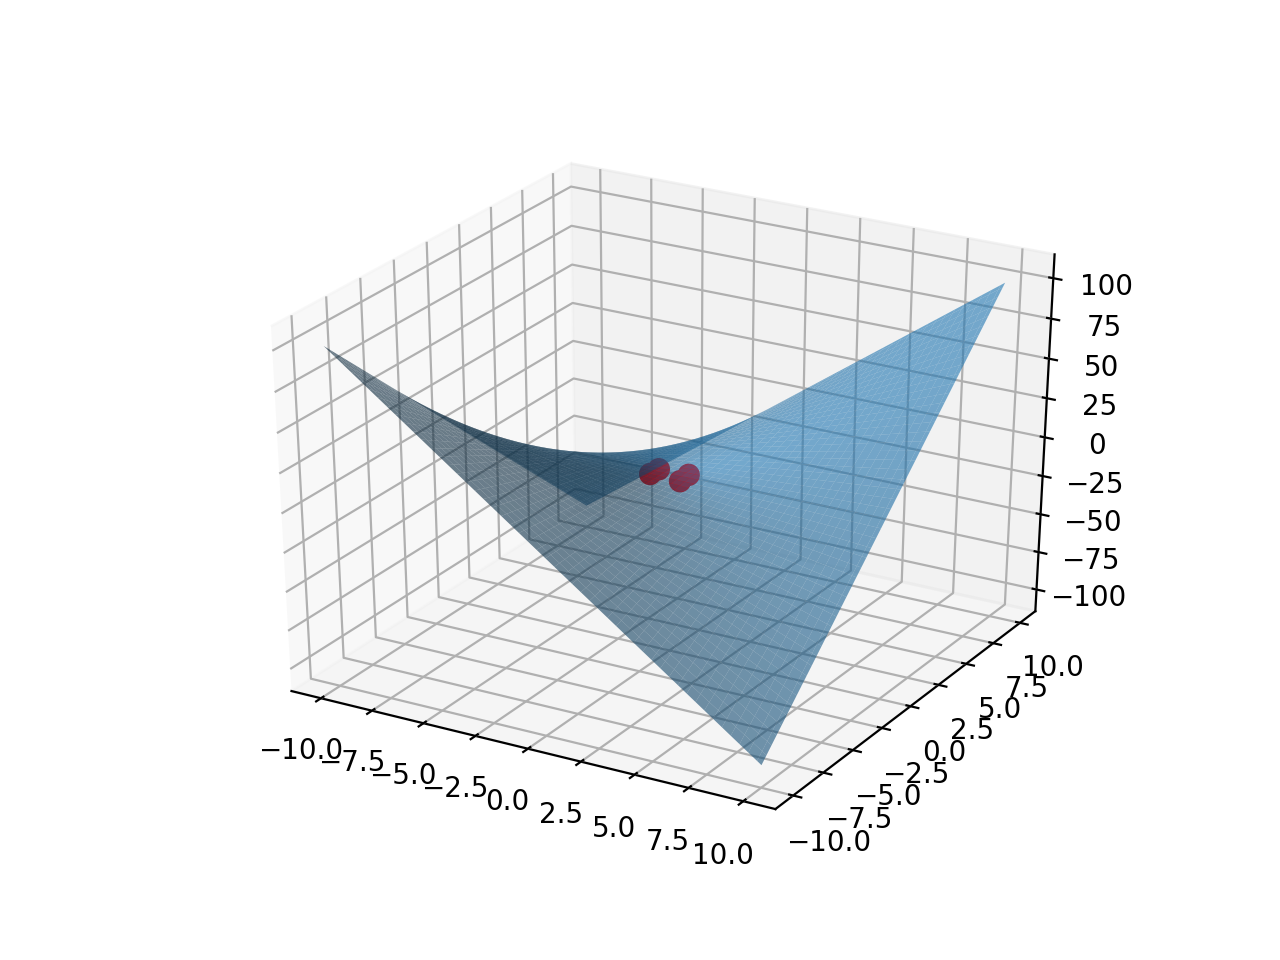

In [24]:
%lprun -f lagrange lagrange(['x', 'y'], 'x*y', 'x**2 + 4*y**2 - 1', {'x':[-10, 10], 'y': [-1, 1]})

Timer unit: 1e-06 s

Total time: 0.384791 s
File: <ipython-input-5-14388bbead8d>
Function: lagrange at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def lagrange(varnames, func, restriction, bounds=None):
     2                                               """
     3                                               varnames: ['x', 'y']
     4                                               func: 'x*y'
     5                                               restriction: 'x**2 + 4*y**2 - 1'
     6                                               bounds: {'x':[-10, 10], 'y': [-1, 1]} 
     7                                               """
     8         1        125.0    125.0      0.0      args = sympy.symbols(varnames)
     9         1       2643.0   2643.0      0.7      func = sympy.sympify(func)
    10         1       3140.0   3140.0      0.8      restriction = sympy.sympify(restriction)
    11         1          9.0      9.0      0.0      lambda_ = sympy.Symbol('lambda')
    12         1         18.0     18.0      0.0      lagrangian = func + lambda_*restriction
    13         1       1649.0   1649.0      0.4      partial_first = [lagrangian.diff(arg) for arg in args+[lambda_]]
    14         1     133161.0 133161.0     34.6      stationary_points = sympy.solve(partial_first, args+[lambda_], dict=True)
    15         5          6.0      1.2      0.0      for point in stationary_points:
    16         4          6.0      1.5      0.0          point.pop(lambda_)
    17                                               
    18         1          0.0      0.0      0.0      if bounds:
    19         1      16499.0  16499.0      4.3          stationary_points = _filter_points(stationary_points, bounds)
    20                                               
    21         1       3533.0   3533.0      0.9      hesse = _get_hessian(func, args)
    22         1     214313.0 214313.0     55.7      _show_extrema(func, stationary_points)
    23         1       9689.0   9689.0      2.5      return [(point, _check_point(hesse, point)) for point in stationary_points]

In [16]:
def _get_hessian(func, args):
    return sympy.Matrix([[func.diff(arg1, arg2) for arg1 in args] for arg2 in args])

def _check_point(hesse, point):
    substituted = hesse.subs(point)
    minor_dets = [substituted[:i, :i].det() for i in range(1, hesse.shape[0] + 1)]
    if all(det > 0 for det in minor_dets):
        return 'min'
    elif all(det < 0 for det in minor_dets[::2]) and all(det > 0 for det in minor_dets[1::2]):
        return 'max'
    else:
        return 'saddle'
    
def _filter_points(points, bounds):
    suitable = []
    for point in points:
        is_suitable = True
        for arg in point:
            if not(bounds[arg.name][0] <= point[arg] <= bounds[arg.name][1]):
                is_suitable = False
        if is_suitable:
            suitable.append(point)
    return suitable
    
def _show_extrema(func, points):
    args = list(points[0].keys())
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_linsp = np.linspace(-10, 10, 100)
    y_linsp = np.linspace(-10, 10, 100)
    x_linsp, y_linsp = np.meshgrid(x_linsp, y_linsp)
    z_linsp = sympy.lambdify(args, func)(x_linsp, y_linsp)
    x = [float(point[args[0]]) for point in points]
    y = [float(point[args[1]]) for point in points]
    z = [float(func.subs(point)) for point in points]
    #ax.set_xlim(-0.5, 1.5)
    #ax.set_ylim(-2, 2)
    #ax.set_zlim(-2, 2)
    ax.scatter(x, y, z, c='red', s=50, alpha=1)
    ax.plot_surface(x_linsp, y_linsp, z_linsp, alpha=0.6)

In [17]:
def find_local_extremas(varnames, func, bounds=None):
    """
    varnames: ['x', 'y']
    func: 'y*(x**2) + x*(y**3) - x*y'
    bounds: {'x':[-10, 10], 'y': [-1, 1]} 
    """
    args = sympy.symbols(varnames)
    sympifyed = sympy.sympify(func)
    partial_first = [sympifyed.diff(arg) for arg in args]
    stationary_points = sympy.solve(partial_first, args, dict=True)
    
    if bounds:
        stationary_points = _filter_points(stationary_points, bounds)
    
    hesse = _get_hessian(sympifyed, args)
    _show_extrema(sympifyed, stationary_points)
    return [(point, _check_point(hesse, point)) for point in stationary_points]

<IPython.core.display.Javascript object>


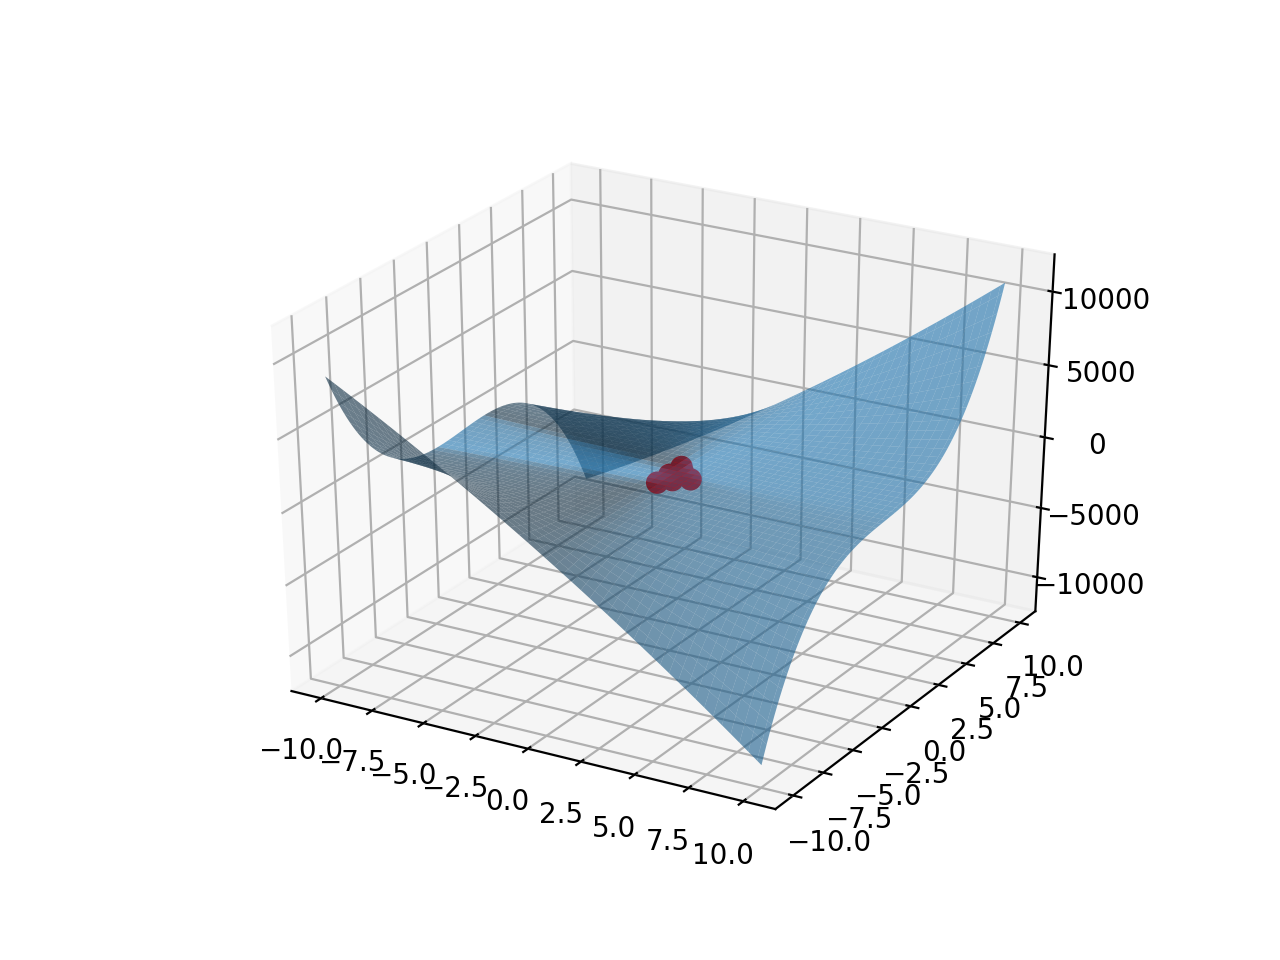

[({x: 0, y: -1}, 'saddle'),
 ({x: 0, y: 0}, 'saddle'),
 ({x: 0, y: 1}, 'saddle'),
 ({x: 2/5, y: -sqrt(5)/5}, 'max'),
 ({x: 2/5, y: sqrt(5)/5}, 'min'),
 ({x: 1, y: 0}, 'saddle')]

In [18]:
find_local_extremas(['x', 'y'], 'y*(x**2) + x*(y**3) - x*y')

In [5]:
def lagrange(varnames, func, restriction, bounds=None):
    """
    varnames: ['x', 'y']
    func: 'x*y'
    restriction: 'x**2 + 4*y**2 - 1'
    bounds: {'x':[-10, 10], 'y': [-1, 1]} 
    """
    args = sympy.symbols(varnames)
    func = sympy.sympify(func)
    restriction = sympy.sympify(restriction)
    lambda_ = sympy.Symbol('lambda')
    lagrangian = func + lambda_*restriction
    partial_first = [lagrangian.diff(arg) for arg in args+[lambda_]]
    stationary_points = sympy.solve(partial_first, args+[lambda_], dict=True)
    for point in stationary_points:
        point.pop(lambda_)
    
    if bounds:
        stationary_points = _filter_points(stationary_points, bounds)
    
    hesse = _get_hessian(func, args)
    _show_extrema(func, stationary_points)
    return [(point, _check_point(hesse, point)) for point in stationary_points]

<IPython.core.display.Javascript object>


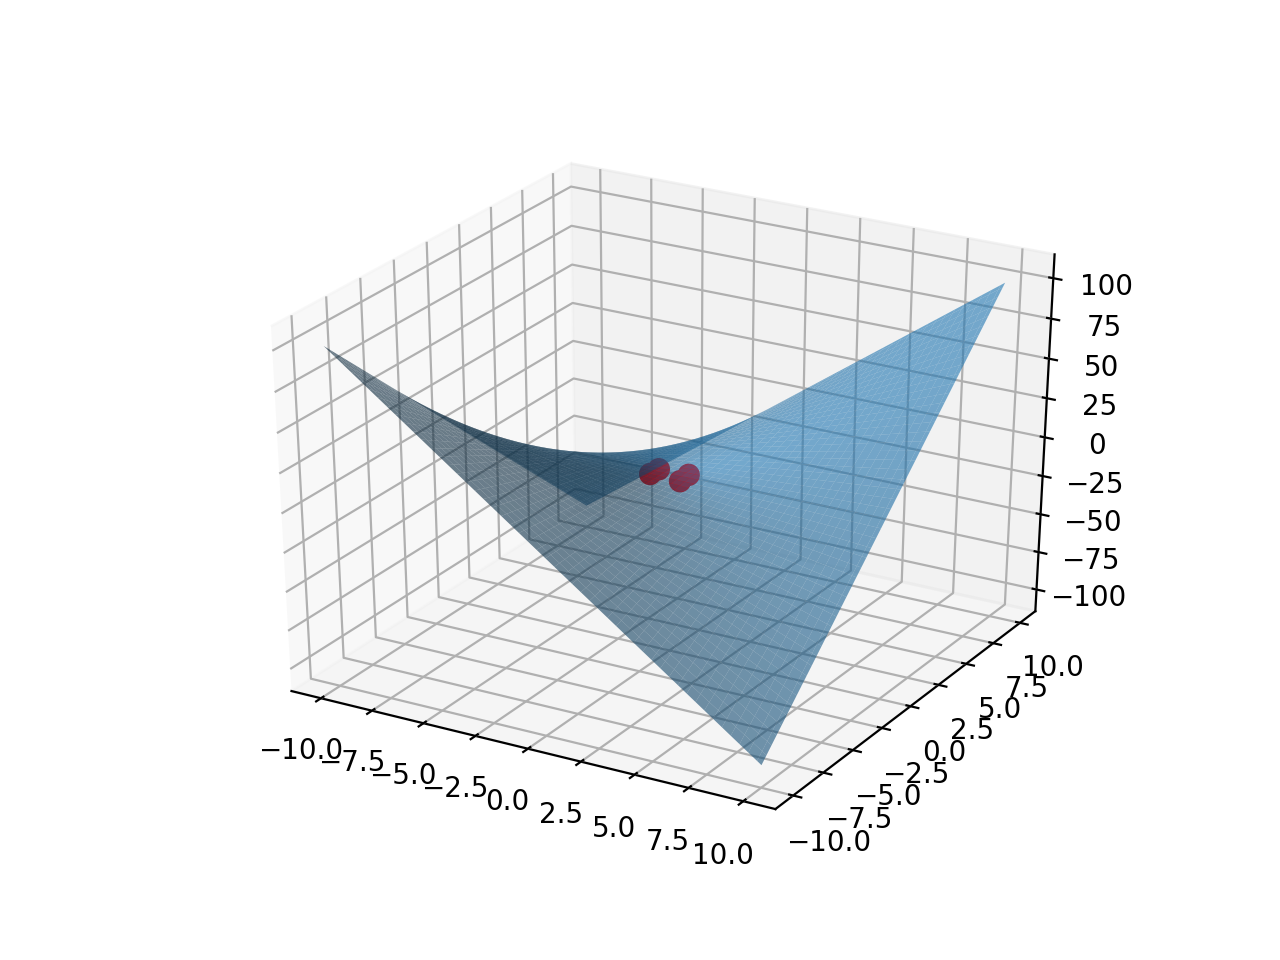

[({x: -sqrt(2)/2, y: -sqrt(2)/4}, 'saddle'),
 ({x: sqrt(2)/2, y: sqrt(2)/4}, 'saddle'),
 ({x: -sqrt(2)/2, y: sqrt(2)/4}, 'saddle'),
 ({x: sqrt(2)/2, y: -sqrt(2)/4}, 'saddle')]

In [6]:
lagrange(['x', 'y'], 'x*y', 'x**2 + 4*y**2 - 1', {'x':[-10, 10], 'y': [-1, 1]})

In [7]:
[{1: 2}].copy()

[{1: 2}]